# Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

tf.__version__

'2.12.0'

In [22]:
SLICE_DURATION = 0.1
SAMPLING_RATE = 16000
N_FFT = 512
HOP_LENGTH = N_FFT // 4
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000

In [3]:
def get_sliced_audio_samples(path, slice_duration, sampling_rate):
    y, sr = librosa.load(path, sr=sampling_rate, mono=True)
    samples_per_slice = int(slice_duration * sampling_rate)
    num_slices = int(len(y) / samples_per_slice)
    rounded_num_samples = num_slices * samples_per_slice
    rounded_y = y[:rounded_num_samples]
    return rounded_y.reshape(num_slices, samples_per_slice)

In [4]:
slices = get_sliced_audio_samples("males/0.wav", SLICE_DURATION, SAMPLING_RATE)

In [5]:
random_slice = slices[np.random.randint(len(slices))]

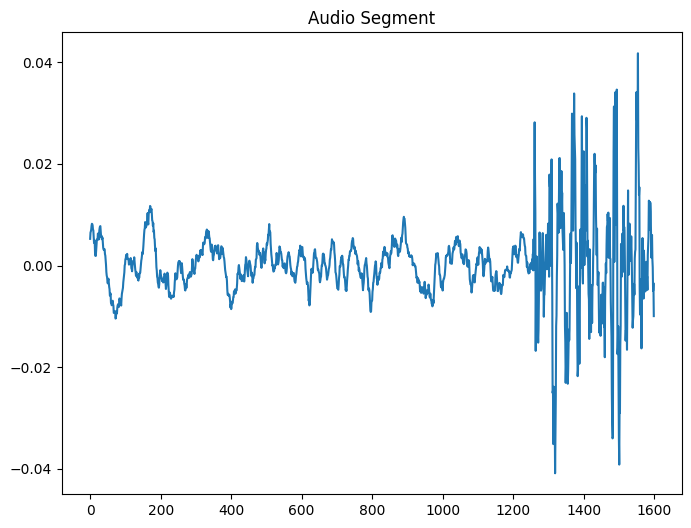

In [6]:
plt.figure(figsize=(8, 6))
plt.title('Audio Segment')
plt.plot(random_slice)

In [7]:
def get_stft(audio_slice, n_fft=N_FFT, hop_length=HOP_LENGTH):
    ft = librosa.stft(audio_slice, n_fft=n_fft, hop_length=hop_length)
    return abs(ft)

In [8]:
def plot_stft(ft, sampling_rate):
    db = librosa.amplitude_to_db(ft, ref=np.max)
    librosa.display.specshow(db, sr=sampling_rate, y_axis='log', x_axis='time')

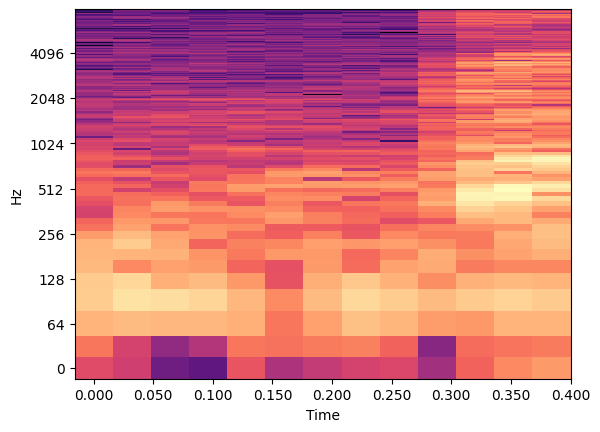

In [9]:
stft = get_stft(random_slice)
plot_stft(stft, SAMPLING_RATE)

In [10]:
def get_audio_slices_stft(path, slice_duration=SLICE_DURATION, sampling_rate=SAMPLING_RATE):
    audio_slices = get_sliced_audio_samples(path, slice_duration, sampling_rate)
    return np.array([get_stft(norm) for norm in audio_slices])

In [11]:
stft = get_audio_slices_stft("males/0.wav")
stft.shape, stft[0]

((55, 257, 13),
 array([[3.78686666e-01, 1.61183581e-01, 2.27720058e-03, ...,
         4.37632529e-03, 5.65502122e-02, 2.02282339e-01],
        [4.17160451e-01, 1.80539697e-01, 4.29245755e-02, ...,
         1.21518165e-01, 1.53942823e-01, 3.25904578e-01],
        [6.98493361e-01, 4.71687883e-01, 3.02227139e-01, ...,
         2.64252096e-01, 5.38194060e-01, 5.54516673e-01],
        ...,
        [1.53993035e-03, 1.14687392e-03, 9.84411687e-04, ...,
         7.39572162e-04, 7.31214648e-04, 2.13350030e-03],
        [1.79480389e-03, 8.69272626e-04, 1.28968130e-03, ...,
         8.10807978e-04, 1.67462602e-03, 2.71338481e-03],
        [1.83915044e-03, 1.22640282e-03, 1.44389004e-03, ...,
         9.09057795e-04, 3.52817064e-04, 2.70274119e-03]], dtype=float32))

In [26]:
STFT_SHAPE = stft.shape[-2:]
STFT_SHAPE

(257, 13)

# Create Train and Test Splits

In [12]:
male_voice_dir = "males"
female_voice_dir = "females"

In [13]:
def get_file_paths_from_dir(path):
    files = []

    for (_, _, filenames) in os.walk(path):
        files += [path + "/" + filename for filename in filenames]

    return files

In [14]:
file_paths = []
labels = []

male_voice_files = get_file_paths_from_dir(male_voice_dir)
file_paths += male_voice_files
labels += [1.0] * len(male_voice_files)

female_voice_files = get_file_paths_from_dir(female_voice_dir)
file_paths += female_voice_files
labels += [0.0] * len(female_voice_files)

In [27]:
train_files, val_files, train_labels, val_labels = train_test_split(
    file_paths,
    labels,
    test_size=0.1,
    shuffle=True,
    random_state=42
)

len(train_files), len(val_files), len(train_labels), len(val_labels)

(5393, 600, 5393, 600)

# Create Datasets

In [28]:
def audio_preprocess(file_path, label):
    slice_stfts = get_audio_slices_stft(file_path.numpy())
    labels = np.array([label.numpy()] * len(slice_stfts))
    return slice_stfts, labels

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset = train_dataset.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)
train_dataset = train_dataset\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [31]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset = val_dataset.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)
val_dataset = val_dataset\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

In [32]:
for audio_slice, label in train_dataset.take(2):
    print(audio_slice.shape)
    print(label.shape)

(128, 257, 13)
(128,)
(128, 257, 13)
(128,)


2023-06-10 01:24:47.016131: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [33]:
for audio_slice, label in val_dataset.take(2):
    print(audio_slice.shape)
    print(label.shape)

(128, 257, 13)
(128,)
(128, 257, 13)
(128,)


2023-06-10 01:25:16.337120: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
